# Анализ оттока клиентов в сети фитнес-клубов
# Задача
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.
Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

1) выделить целевые группы клиентов;

2) предложить меры по снижению оттока;

3) определить другие особенности взаимодействия с клиентами.

* gender — пол;
* Near_Location — проживание или работа в районе, где находится фитнес-центр;
* Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* Phone — наличие контактного телефона;
* Age — возраст;
* Lifetime — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

* Contract_period — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
* Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);
* Group_visits — факт посещения групповых занятий;
* Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
* Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
* Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

## Шаг. Загрузите данные

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

import numpy as np

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, precision_score, recall_score

import warnings

warnings.simplefilter('ignore')

In [2]:
RANDOM_SEED = 0

In [3]:
df = pd.read_csv("/datasets/gym_churn.csv")  

### Выведем произвольные строки из нашей таблицы чтобы увидеть данные.

In [4]:
display(pd.concat([df.sample(5, random_state=RANDOM_SEED)]).reset_index(drop=True))

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,0,1,1,1,1,12,1,29,260.507459,12.0,2,2.348167,2.323455,0
1,0,0,0,0,1,1,1,27,48.087954,1.0,0,1.003281,0.728397,1
2,0,0,1,0,1,6,0,30,24.620589,5.0,2,0.000000,0.000000,0
3,1,1,0,0,1,1,1,27,139.893107,1.0,0,2.322132,1.838436,1
4,1,0,1,0,0,12,0,29,89.657794,12.0,1,3.521502,3.368137,0


### Переведем названия столбцов к нижнему регистру.

In [5]:
df.columns = map(str.lower, df.columns)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Пропущенных данных нет, всего в таблице 4000 строк и 14 столбцов. Отсутствующих признаков не наблюдается.

### Видим, что можем понизить разрядность данных чтобы оптимизировать работу кода.

In [7]:
signed_features = df.select_dtypes(include='int64').columns
float_features = df.select_dtypes(include='float64').columns

df[signed_features] = df[signed_features].apply(pd.to_numeric, downcast='signed')
df[float_features] = df[float_features].apply(pd.to_numeric, downcast='float')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int8
near_location                        4000 non-null int8
partner                              4000 non-null int8
promo_friends                        4000 non-null int8
phone                                4000 non-null int8
contract_period                      4000 non-null int8
group_visits                         4000 non-null int8
age                                  4000 non-null int8
avg_additional_charges_total         4000 non-null float32
month_to_end_contract                4000 non-null float32
lifetime                             4000 non-null int8
avg_class_frequency_total            4000 non-null float32
avg_class_frequency_current_month    4000 non-null float32
churn                                4000 non-null int8
dtypes: float32(4), int8(10)
memory usage: 101.7 KB


После обработки оптимизировали работу кода почти в 4 раза.

### Выводы
В данном блоке мы оценили размер датафрейма - всего в таблице 4000 строк и 14 столбцов. Пропущенных данных нет, отсутствующих признаков не наблюдается. Перевели названия столбцов к нижнему регистру, а также оптимизировали работу кода почти в 4 раза, понизив разрядность данных.

## Шаг. Проведите исследовательский анализ данных (EDA)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943726,96.355606,0.148205,68.868832,136.220161,210.949619,552.590759
month_to_end_contract,4000.0,4.322750,4.191298,1.000000,1.000000,1.000000,6.000000,12.000000


Из таблицы видим, что наибольший разброс в данных наблюдается у показателя avg_additional_charges_total (стандартное отклонение 96.35), при этом среднее - 146.9 (суммарная выручка от дополнительных процедур в фитнес центре). Почти у 85% клиентов фитнес центр находится рядом с работой или домом, примерно 41% клиентов посещают групповые занятия, 31% пришли по рекомендации друзей. Средний возраст клиентов - 29 лет, но зал посещают люди от 18 до 41 года и в гендерном соотношении разделены практически одинаково. Почти половина клиентов - сотрудники компании-партнёра клуба. Факт оттока в текущем месяце зафиксирован у 26% клиентов.

In [10]:
df.groupby('churn').mean().reset_index()

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445709,5.283090,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082901,1.662583,0.990575,1.474995,1.044546


В текущем месяце был зафиксирован равномерный отток как мужчин, так и женщин, осталось тоже одинаковое соотношение полов. Близкая локация сыграла интересную роль, почти 76% из тех, кто прекратил посещать зал либо работают либо живут возле фитнес центра. Примерно в первый месяц люди перестают посещать зал, но при этом те, кто полны энтузиазма песещают зал в среднем 5 месяцев. Люди, посещающие зал в настоящее время в среднем тратят больше денег на дополнительные процедуры и сервисы.

### Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

In [11]:
pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.2)
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install seaborn --upgrade

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.2)
Note: you may need to restart the kernel to use updated packages.


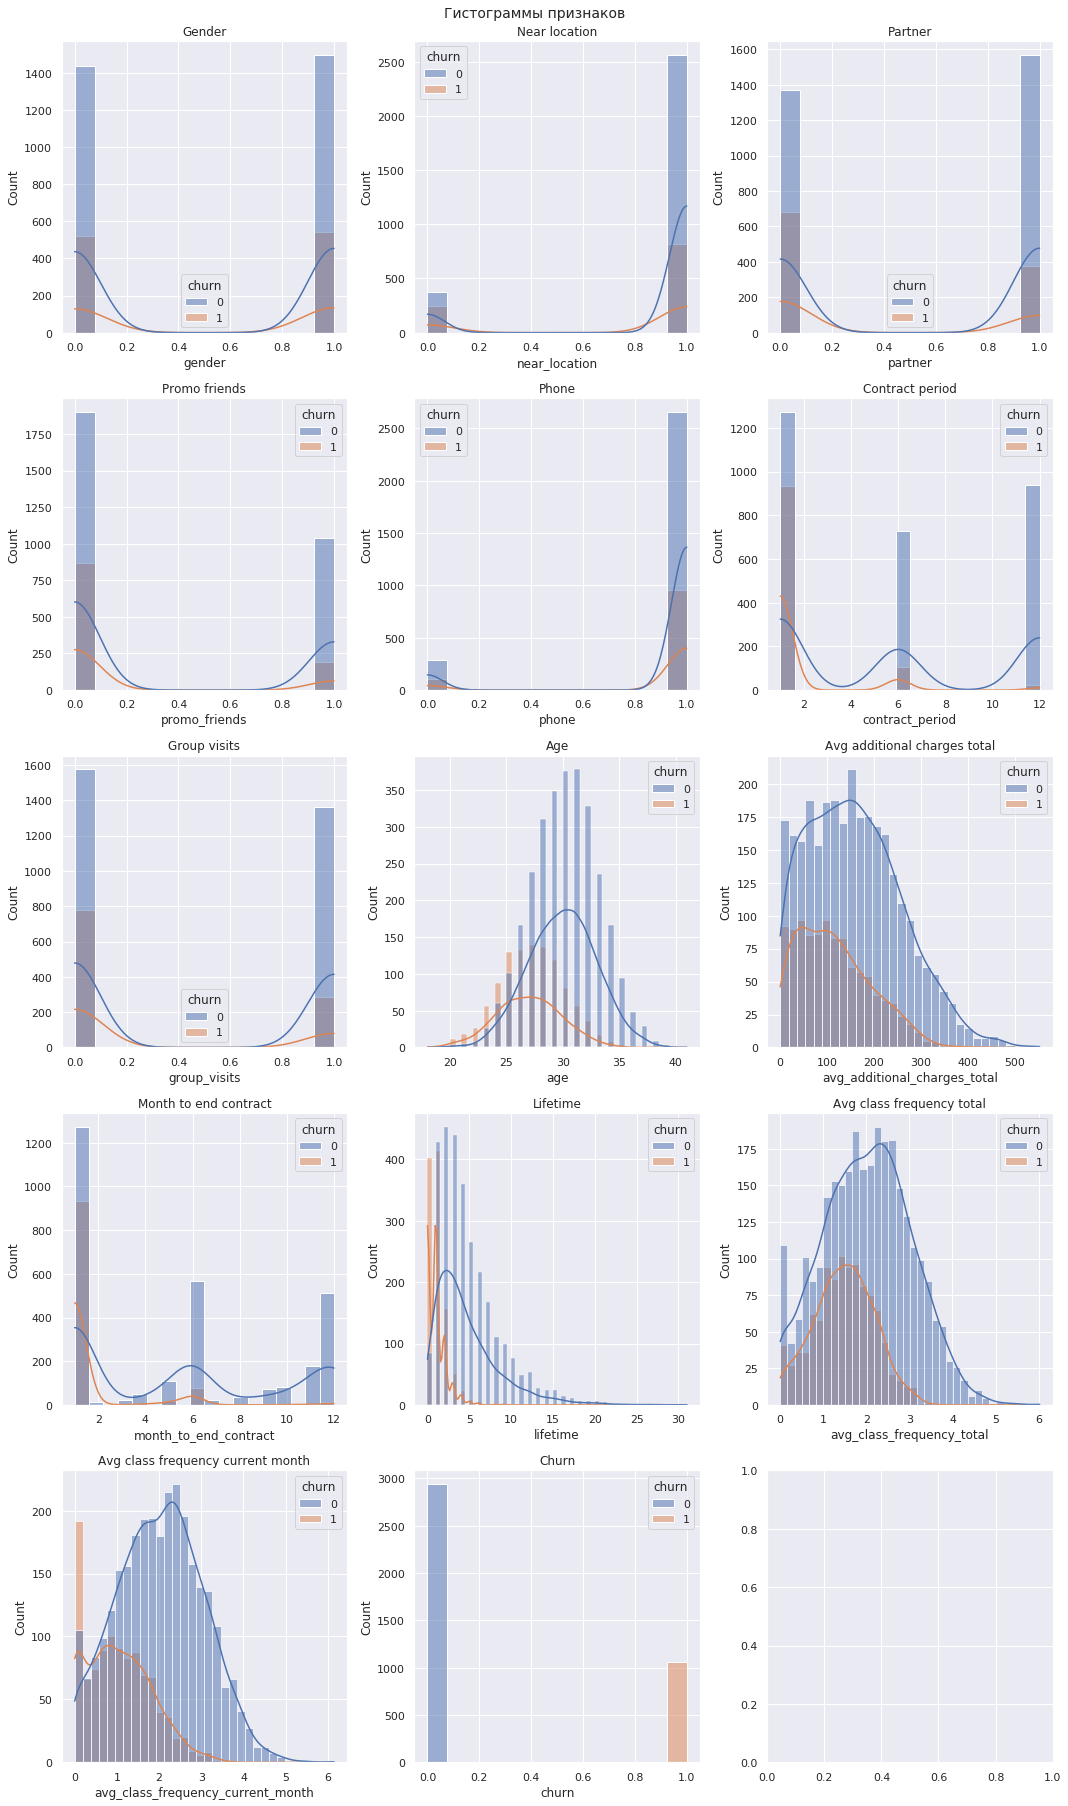

In [13]:
WIDTH = 3
plot_amount = len(df.columns)
height = plot_amount//WIDTH + 1

fig, axs = plt.subplots(height, WIDTH, figsize=(15, 25))
fig.suptitle('Гистограммы признаков',  y=1.003, size=14)

for item, ax in zip(df.columns, np.ravel(axs)):
    sns.histplot(data = df, x=item, hue='churn', ax=ax, kde=True)
    ax.set_title(item.capitalize().replace('_', ' '), size=12)

plt.tight_layout()
plt.show()

Ближе всего к нормальному распределение признака возраста посещающих фитнес центр. Причем это касается как клиентов, которые регулярно посещают фитнес центр, так и клиентов попавших в фактор оттока. Чуть больше 200 человек, у которых не был зафиксирован факт оттока воспользовались дополнительными услугами фитнес центра и принесли выручку в районе 200 у.е. с человека. По гистограмме видим, что все те, кто уходят, делают это в первые месяцы посещения зала. Чаще всего люди покупают абонемент на месяц, но при этом у данной категории клиентов наблюдается факт оттока в большей степени. Те, кто покупают абонемент на 12 месяцев, реже всего уходят в дальнейшем.

In [14]:
corr_matrix = df.corr()

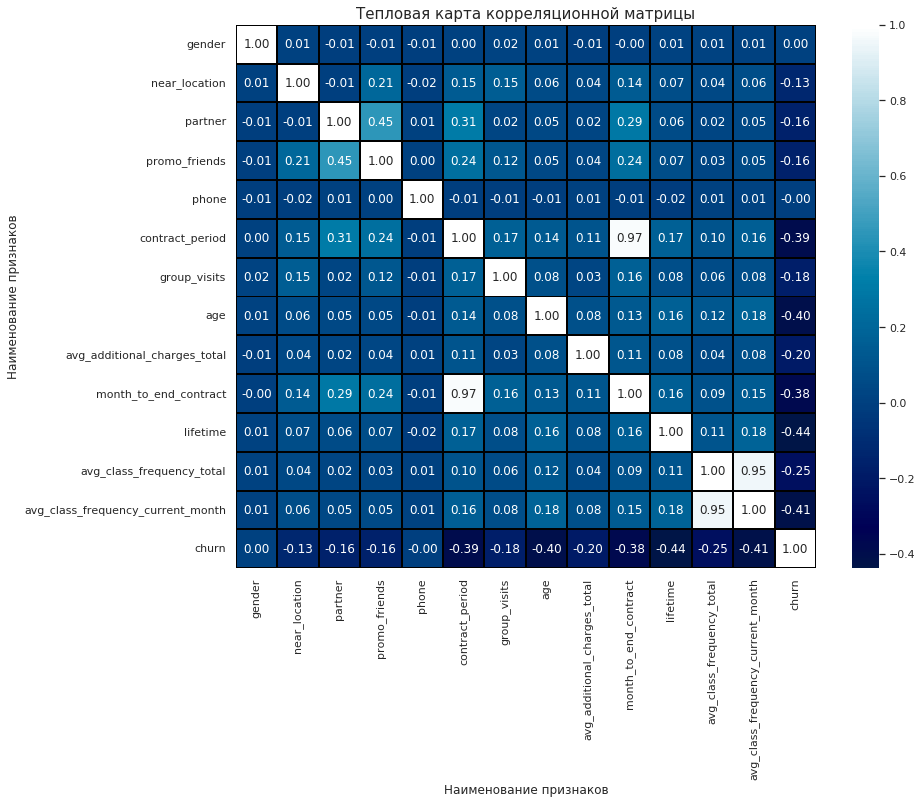

In [15]:
plt.figure(figsize = (13, 10))
plt.title('Тепловая карта корреляционной матрицы', size = 15)
sns_plot = sns.heatmap(corr_matrix, annot=True, fmt='.2f', 
                      linewidth=1, linecolor='black', vmax=1, center=0, cmap='ocean')
fig = sns_plot.get_figure()
plt.xlabel('Наименование признаков')
plt.ylabel('Наименование признаков')
plt.show()

Видим наличие корреляции между переменными month_to_end_contract и contract_period, а также между переменными avg_class_frequency_total и avg_class_frequency_current_month, что неудевительно, это взаимозависимые переменные.

### Выводы
* Наибольший разброс в данных наблюдается у показателя avg_additional_charges_total (стандартное отклонение 96.35), при этом среднее - 146.9 (суммарная выручка от дополнительных процедур в фитнес центре).
* Почти у 85% клиентов фитнес центр находится рядом с работой или домом, примерно 41% клиентов посещают групповые занятия, 31% пришли по рекомендации друзей.
* Средний возраст клиентов - 29 лет, но зал посещают люди от 18 до 41 года и в гендерном соотношении разделены практически одинаково.
* Почти половина клиентов - сотрудники компании-партнёра клуба. Факт оттока в текущем месяце зафиксирован у 26% клиентов.

* В текущем месяце был зафиксирован равномерный отток как мужчин, так и женщин, осталось тоже одинаковое соотношение полов. Близкая локация сыграла интересную роль, почти 76% из тех, кто прекратил посещать зал либо работают либо живут возле фитнес центра.

* Примерно в первый месяц люди перестают посещать зал, но при этом те, кто полны энтузиазма песещают зал в среднем 5 месяцев. Люди, посещающие зал в настоящее время в среднем тратят больше денег на дополнительные процедуры и сервисы.

* Ближе всего к нормальному распределение признака возраста посещающих фитнес центр. Причем это касается как клиентов, которые регулярно посещают фитнес центр, так и клиентов попавших в фактор оттока.

* Чуть больше 200 человек, у которых не был зафиксирован факт оттока воспользовались дополнительными услугами фитнес центра и принесли выручку в районе 200 у.е. с человека.
* Все те, кто уходят, делают это в первые месяцы посещения зала. Чаще всего люди покупают абонемент на месяц, но при этом у данной категории клиентов наблюдается факт оттока в большей степени. Те, кто покупают абонемент на 12 месяцев, реже всего уходят в дальнейшем.
* Мы зафиксировали наличие корреляции между переменными month_to_end_contract и contract_period, а также между переменными avg_class_frequency_total и avg_class_frequency_current_month, что неудевительно, это взаимозависимые переменные.

## Шаг. Постройте модель прогнозирования оттока клиентов

### Разделим наши данные на признаки (матрица X) и целевую переменную (y).

In [16]:
X = df.drop('churn', axis=1)
y = df['churn']

### Разделяем модель на обучающую и валидационную выборку.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = RANDOM_SEED)

In [18]:
# обучаем StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

#Преобразовываем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [19]:
#Задаем алгоритм для модели логистической регрессии
lr_model = LogisticRegression(solver = 'lbfgs', random_state=RANDOM_SEED)

#Обучим модель
lr_model.fit(X_train_st, y_train)

#Воспользуемся обученной моделью чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

In [20]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state=RANDOM_SEED)

# обучим модель случайного леса
rf_model.fit(X_train, y_train)

# воспользуемся обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test) 
rf_probabilities = rf_model.predict_proba(X_test)[:,1] 

In [21]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    '''
    y_true - зависимая переменная валидационной выборки
    y_pred - прогнозы обученной модели
    y_proba - вероятности
    '''
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [22]:
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83


In [23]:
print_all_metrics(
    y_test, 
    rf_predictions,
    rf_probabilities,
    title = 'Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.82


Метрика Accuracy одинакова в обоих моделях и равна 0.92, что является неплохим результатом - доля верно угаданных ответов из всех прогнозов. Чем ближе значение accuracy к 100%, тем лучше. Метрика Precision характеризует долю правильных ответов только среди целевого класса. В модели логистической регрессии данная метрика лучше и равна 0.85. Recall метрика показывает, сколько реальных объектов "1" класса мы смогли обнаружить с помощью модели. Для случая логистической регрессии данная метрика также лучше.

### Выводы
Мы построили модели прогнозирования оттока клиентов: модель логистической регрессии и модель случайного леса.

Метрика Accuracy одинакова в обоих моделях и равна 0.92, что является неплохим результатом - доля верно угаданных ответов из всех прогнозов. Чем ближе значение accuracy к 100%, тем лучше. Метрика Precision характеризует долю правильных ответов только среди целевого класса. В модели логистической регрессии данная метрика лучше и равна 0.85. Recall метрика показывает, сколько реальных объектов "1" класса мы смогли обнаружить с помощью модели. Для случая логистической регрессии данная метрика также лучше.

Следовательно, модель логистической регрессии на основании метрик показала себя лучше.

## Шаг. Сделайте кластеризацию клиентов

In [24]:
# стандартизация данных
sc = StandardScaler()
X_sc = sc.fit_transform(X)

#Построение матрицы расстояний
linked = linkage(X_sc, method = 'ward')

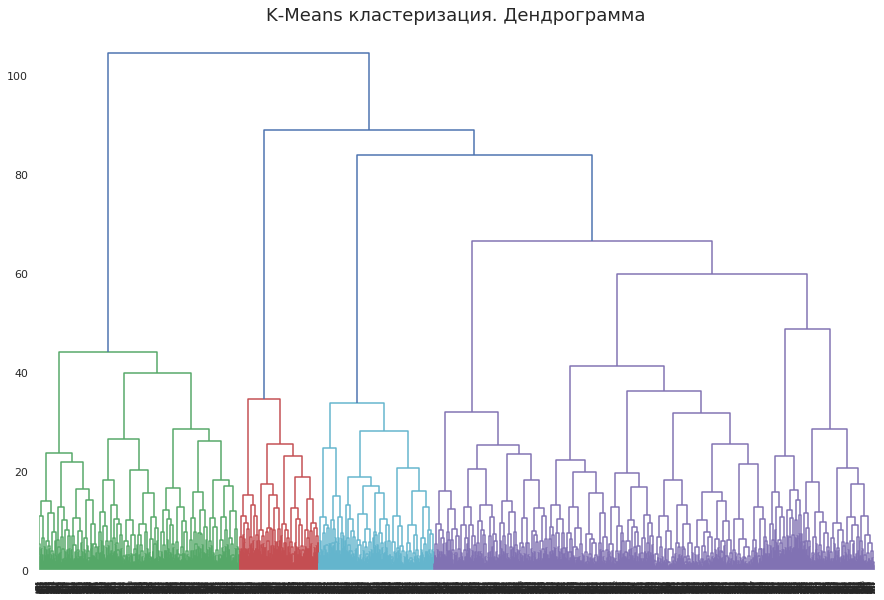

In [25]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('K-Means кластеризация. Дендрограмма', size=18)
plt.show() 

На основании полученного графика можно выделить 4 класса.

### Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Договоримся за число кластеров принять n=5.

In [26]:
km = KMeans(n_clusters = 5, random_state=RANDOM_SEED) # задаём число кластеров, равное 5
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров 

In [27]:
# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
df.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706970,9.950544,4.738872,1.983305,1.976225,0.027695
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957657,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457504,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622208,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473,0.068100


В гендерном соотношении все кластеры имеют схожее распределение мужчин/женщин, кроме кластера 4 - у него наибольшее среднее значение 0.56. Все клиенты, принадлежащие кластеру 3 либо проживают рядом с фитнес залом/ либо работают неподалеку, напротив, клиенты, относящиеся к кластеру 0 живут далеко от фитнес центра. Средние значения признака partner - сотрудник компании-партнёра клуба сильно варьируются от кластера к кластеру. Наименьшее значение у кластера 3 - 0,35, а наибольшее у кластера 0 - 0,78. Посещение зала по рекомендации друга: для данного признака также замечена сильная вариабельность от кластера к кластеру - для кластера 2, например, среднее значение равно 0.08, а для кластера 0 - аж 0.57. Среднее для признака длительность текущего абонемента наибольшее у кластера 0 - 10.88. Среднее признака групповых посещений занятий в зале наименьшее у кластера 2 - 0,22. Возраст клиентов не сильно варьируется от кластера к кластеру и везде составляет около 30 лет. Среднее срока окончания контракта наименьшее у кластера 3 - 1.8, а наибольшее у кластера 0 - почти 9.95.

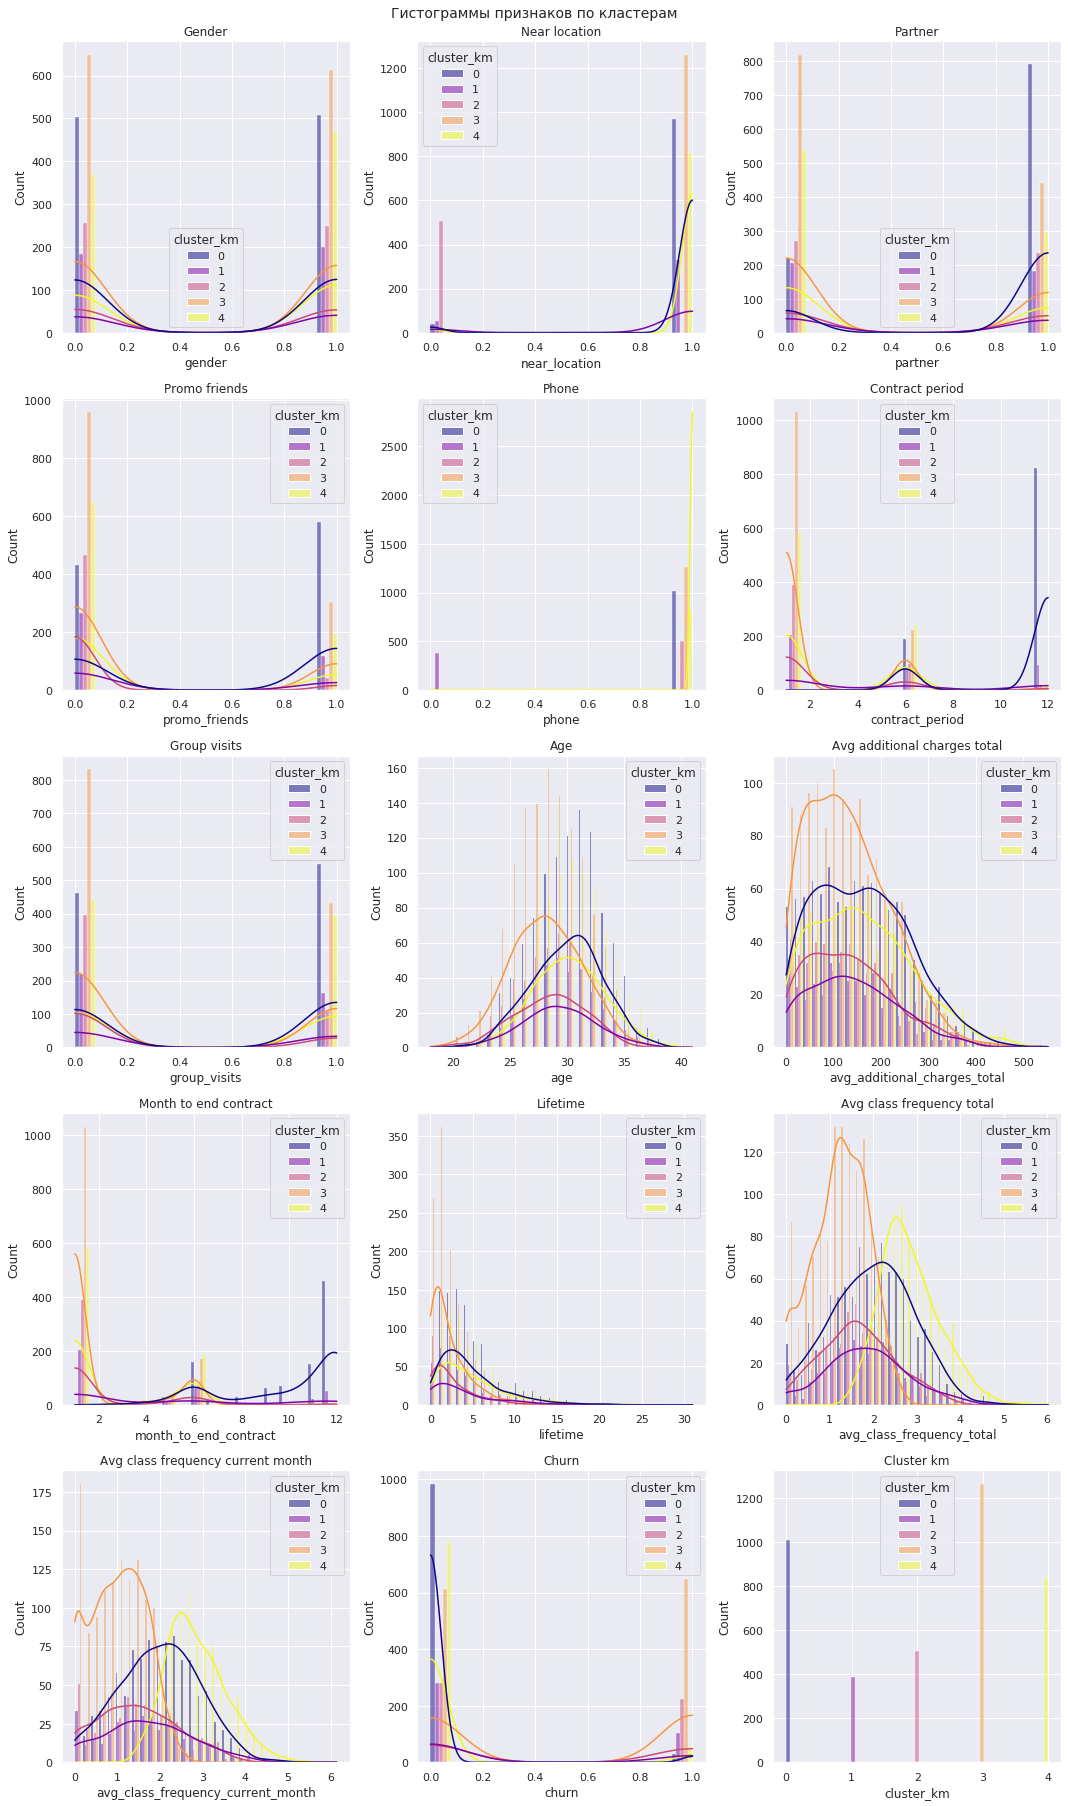

In [28]:
WIDTH = 3
height = 5

fig, axs = plt.subplots(height, WIDTH, figsize=(15, 25))
fig.suptitle('Гистограммы признаков по кластерам',  y=1.003, size=14)

for item, ax in zip(df.columns, np.ravel(axs)):
    sns.histplot(data = df, x=item, hue='cluster_km', ax=ax, kde=True, palette='plasma', multiple='dodge')
    ax.set_title(item.capitalize().replace('_', ' '), size=12)

plt.tight_layout()
plt.show()

* Кластер 0 характеризуется тем, что в нем сосредоточена наибольшая часть сотрудников компаний-партнеров клуба, также он характерен тем, что в нем много клиентов длительность текущего действующего абонемента которых самая большая - 12 месяцев. Клиенты, попавшие в данный кластер больше других посещают групповые занятия и срок до окончания действия контракта составляет порядка 12 месяцев в большинстве случаев. Для данного кластера доля оттока клиентов наименьшая.
* Кластер 1 характерен тем, что у всех клиентов данной группы отсутствует номер телефона и средние значения всех признаков меньше, чем у клиентов из других кластеров. И при этом в целом в данной группе наименьшее количество людей.
* Кластер 2 характеризуется тем, что в нем больше всего клиентов, у которых фитнес зал находится далеко от дома/работы. При этом в целом в группе около 500 клиентов.
* Кластер 3 характеризуется наибольшим количеством клиентов среди всех остальных кластеров, в нем у всех клиентов зал находится рядом с домом/работой. В этом кластере много людей пришло по рекомендации друзей, но также в нем у многих клиентов длительность текущего действующего абонемента месяц - 3 месяца.
* Кластер 4 характеризуется тем, что у всех клиентов фитнес клуба есть номера телефонов, при этом данная группа сильно уступает другим кластерам в значениях, при этом почти у всех клиентов в данном кластере зафиксирован факт оттока.

### Для каждого полученного кластера посчитаем долю оттока.

In [29]:
df.groupby('cluster_km').agg({'churn':'mean'}).reset_index().rename(columns={'churn':'churn_rate'})

,cluster_km,churn_rate
0,0,0.027695
1,1,0.267532
2,2,0.443564
3,3,0.514263
4,4,0.068100


Наиболее перспективные кластеры - 2 и 3 кластер. Склонные к оттоку - кластеры 0 и 4.

### Выводы
На основании полученной дендрограммы мы определили, что можно выделить 4 класса.

Мы обучили модель кластеризации на основании алгоритма K-Means и спрогнозировали кластеры клиентов и получили, что:

* Кластер 0 характеризуется тем, что в нем сосредоточена наибольшая часть сотрудников компаний-партнеров клуба, также он характерен тем, что в нем много клиентов длительность текущего действующего абонемента которых самая большая - 12 месяцев. Клиенты, попавшие в данный кластер больше других посещают групповые занятия и срок до окончания действия контракта составляет порядка 12 месяцев в большинстве случаев. Для данного кластера доля оттока клиентов наименьшая.
* Кластер 1 характерен тем, что у всех клиентов данной группы отсутствует номер телефона и средние значения всех признаков меньше, чем у клиентов из других кластеров. И при этом в целом в данной группе наименьшее количество людей.
* Кластер 2 характеризуется тем, что в нем больше всего клиентов, у которых фитнес зал находится далеко от дома/работы. При этом в целом в группе около 500 клиентов.
* Кластер 3 характеризуется наибольшим количеством клиентов среди всех остальных кластеров, в нем у всех клиентов зал находится рядом с домом/работой. В этом кластере много людей пришло по рекомендации друзей, но также в нем у многих клиентов длительность текущего действующего абонемента месяц - 3 месяца.
* Кластер 4 характеризуется тем, что у всех клиентов фитнес клуба есть номера телефонов, при этом данная группа сильно уступает другим кластерам в значениях, при этом почти у всех клиентов в данном кластере зафиксирован факт оттока.

В гендерном соотношении все кластеры имеют схожее распределение мужчин/женщин, кроме кластера 4 - у него наибольшее среднее значение 0.56. Все клиенты, принадлежащие кластеру 3 либо проживают рядом с фитнес залом/ либо работают неподалеку, напротив, клиенты, относящиеся к кластеру 0 живут далеко от фитнес центра. Средние значения признака partner - сотрудник компании-партнёра клуба сильно варьируются от кластера к кластеру. Наименьшее значение у кластера 3 - 0,35, а наибольшее у кластера 0 - 0,78. Посещение зала по рекомендации друга: для данного признака также замечена сильная вариабельность от кластера к кластеру - для кластера 2, например, среднее значение равно 0.08, а для кластера 0 - аж 0.57. Среднее для признака длительность текущего абонемента наибольшее у кластера 0 - 10.88. Среднее признака групповых посещений занятий в зале наименьшее у кластера 2 - 0,22. Возраст клиентов не сильно варьируется от кластера к кластеру и везде составляет около 30 лет. Среднее срока окончания контракта наименьшее у кластера 3 - 1.8, а наибольшее у кластера 0 - почти 9.95.

Наиболее перспективные кластеры - 2 и 3 кластер. Склонные к оттоку - кластеры 0 и 4.

## Шаг. Сформулируйте выводы и сделайте базовые рекомендации по работе с клиентами

* Почти у 85% клиентов фитнес центр находится рядом с работой или домом, примерно 41% клиентов посещают групповые занятия, 31% пришли по рекомендации друзей.
* Средний возраст клиентов - 29 лет, но зал посещают люди от 18 до 41 года и в гендерном соотношении разделены практически одинаково.
* Почти половина клиентов - сотрудники компании-партнёра клуба. Факт оттока в текущем месяце зафиксирован у 26% клиентов.

* В текущем месяце был зафиксирован равномерный отток как мужчин, так и женщин, осталось тоже одинаковое соотношение полов. Близкая локация сыграла интересную роль, почти 76% из тех, кто прекратил посещать зал либо работают либо живут возле фитнес центра.

* Примерно в первый месяц люди перестают посещать зал, но при этом те, кто полны энтузиазма песещают зал в среднем 5 месяцев. Люди, посещающие зал в настоящее время в среднем тратят больше денег на дополнительные процедуры и сервисы.
* Чуть больше 200 человек, у которых не был зафиксирован факт оттока воспользовались дополнительными услугами фитнес центра и принесли выручку в районе 200 у.е. с человека.
* Все те, кто уходят, делают это в первые месяцы посещения зала. Чаще всего люди покупают абонемент на месяц, но при этом у данной категории клиентов наблюдается факт оттока в большей степени. Те, кто покупают абонемент на 12 месяцев, реже всего уходят в дальнейшем.
* Мы зафиксировали наличие корреляции между переменными month_to_end_contract и contract_period, а также между переменными avg_class_frequency_total и avg_class_frequency_current_month, что неудевительно, это взаимозависимые переменные.

Рекомендации для стратегии взаимодействия с клиентами и их удержания:

* Модель логистической регрессии на основании метрик показала себя лучше, следовательно для прогнозирования оттока клиентов лучше использовать именно ее.

* Наличие в базе фитнес центра номера телефона клиента поможет избежать факта оттока, поскольку администратор, например, может иногда звонить и напоминать об преимуществах использования абонемента/ возможно предлагать какие-то акции или дополнительные процедуры.

* Поскольку люди чаще всего бросают занятия фитнесом в первый месяц, можно придумать стратегии стимуляции интереса клиента продолжать посещать зал - например, после 10 посещений занятий в фитнес центре предлагать бесплатную процедуру массажа.

* Поскольку люди чаще всего покупают абонемент на месяц и у этой части клиентов факт оттока выражен в большей степени, можно устроить акции/розыгрыши - типа покупка абонемента на 3 месяца по цене абонемента на 1 месяц.